# Chapter 6: 학습 관련 기술들
>  
> ### ** 6.1** 매개변수 갱신  
> * 신경망 학습의 목적은 손실 함수의 값을 가능한 한 낮추는 매개변수를 찾는 것  
> &nbsp; &nbsp; &rarr; 이는 곧 매개변수의 최적값을 찾는 문제이며, 이러한 문제를 푸는 것을 최적화라고 함
> * 지금까지 최적의 매개변수 값을 찾는 단서로 매개변수의 기울기(미분)을 이용함  
> 매개변수의 기울기를 구해, 기울어진 방향으로 매개변수 값을 갱신하는 일을 반복해서 점점 최적의 값에 다가감  
> &nbsp; &nbsp; &rarr; 확률적 경사 하강법 (SGD)
> * SGD는 매개변수 공간을 무작정 찾는 것보다 '똑똑한' 방법이지만, 문제에 따라서는 SGD보다 똑똑한 방법도 있음

>> ##### 모험가 이야기
>> ![adventure](pic/adventure.png)
>> * 위와 같은 어려운 상황에서 중요한 단서가 되는 것이 땅의 '기울기'
>> * 모험가는 주위 경치는 볼 수 없지만 지금 서 있는 땅의 기울기는 알 수 있음
>> * 지금 서 있는 장소에서 가장 크게 기울어진 방향으로 가는 것이 SGD의 전략  
>> 이를 반복하면 언젠가 '깊은 곳'에 찾아갈 수 있을 것
>>  
>> ##### 확률적 경사 하강법 (SGD)
>> SGD 복습  
>> * $ W \larr W- \eta \frac{\sigma L}{\sigma W} $  
>>      * $W$: 갱신할 가중치 매개변수  
>>      * $\frac{\sigma L}{\sigma W}$: $W$에 대한 손실함수의 기울기  
>>      * $\eta$: 학습률 (0.01이나 0.001과 같은 값을 미리 정해서 사용)  
>>      * $\larr$: 우변의 값으로 좌변의 값을 갱신

In [1]:
# SGD 구현
class SGD:
    def __init__(self, lr=0.01):
        self.lr = lr
    
    def update(self, params, grads):
        for key in params.keys():
            params[key] -= self.lr*grads[key]

>> * 초기화 때 받는 인수 lr: learning rate(학습률)  
>> 이 학습률을 인스턴스 변수로 유지  
>> * `update(params, grads)` 메서드: SGD 과정에서 반복해서 호출
>>      * `params, grads`: 딕셔너리 변수  
>> `params['W1'], grads['W1']` 등과 같이 각각 가중치 매개변수와 기울기를 저장하고 있음
>>  
>> SGD 클래스를 사용하면 신경망 매개변수의 진행을 다음과 같이 수행할 수 있음  
>> ```
>> network = TwoLayerNet(...)  
>> optimizer = SGD()  
>>  
>> for i in range(10000):  
>> ...  
>> x_batch, t_batch = get_mini_batch(...) # 미니배치  
>> grads = network.gradient(x_batch, t_batch)  
>> params = network.params  
>> optimizer.update(params, grads)  
>> ...
>> ```
>> * optimizer: 최적화를 행하는 자, 매개변수 갱신을 수행
>>  
>> * 이처럼 최적화를 담당하는 클래스를 분리해 구현하면 기능을 모듈화하기 좋음

>> ##### SGD의 단점
>> * 문제에 따라서 비효율적인 경우가 있음  
>> ![disad_sgd](pic/disad_sgd.png)
>> ![gradient_disad](pic/gradient_disad.png)
>>  
>> SGD 적용
>> * 탐색 시작 (초깃값) $(x,y) = (-7.0, 2.0)$  
>> ![disad_application_of_sgd](pic/disad_application_of_sgd.png)
>>  
>> * SGD는 그림 6-3과 같은 심하게 굽이진 움직임을 보여줌  
>> &nbsp; &nbsp; &rarr; 상당히 비효율적인 움직임  
>> &nbsp; &nbsp; &rarr; SGD의 단점은 비등방성 함수(anisotropy function)에서는 탐색 경로가 비효율적이라는 것  
>> &nbsp; &nbsp; &nbsp; &nbsp; (anisotropy function: 방향에 따라 성질, 즉 여기에서는 기울기가 달라지는 함수)
>>  
>> * SGD가 지그재그로 탐색하는 근본 원인은 기울어진 방향이 본래의 최솟값과 다른 방향을 가리키기 때문
>> * SGD의 이러한 단점을 개선해주는 기법: Momentum, AdaGrad, Adam

>> ##### Momentum
>> * Momentum: 운동량, 물리와 관계가 있음  
>>  
>> * $ v \larr \alpha v - \eta \frac{\sigma L}{\sigma W} $ &nbsp; &nbsp; &nbsp; [식 6.3]
>> * $ W \larr W+v $ &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; [식 6.4]
>>      * $W$: 갱신할 가중치 매개변수  
>>      * $\frac{\sigma L}{\sigma W}$: $W$에 대한 손실 함수의 기울기
>>      * $\eta$: 학습률
>>      * $v$: 물리에서 말하는 속도
>> * 식 6.3은 기울기 방향으로 힘을 받아 물체가 가속되는 물리 법칙을 나타냄  
>> * 식 6.3의 $\alpha v$ 항은 물체가 아무런 힘을 받지 않을 때 서서히 하강시키는 역할을 함  
>> 물리에서의 마찰, 공기 저항에 해당  
>> * 모멘텀은 공이 그릇의 바닥을 구르는 듯한 움직임을 보여줌  
>> ![momentum_image](pic/momentum_image.png)

In [2]:
import numpy as np

# Momentum 구현
class Momentum:
    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None
    
    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val)
            
        for key in params.keys():
            self.v[key] = self.momentum*self.v[key]-self.lr*grads[key]
            params[key] += self.v[key]

>> * 인스턴스 변수 v: 물체의 속도, 초기화 때는 아무 값도 담지 않음, update()가 처음 호출될 때 매개변수와 같은 구조의 데이터를 딕셔너리 변수로 저장
>>  
>> * 나머지 부분은 식 6.3과 식 6.4를 코드로 옮긴 것
>>  
>> ![optimize_momentum](pic/optimize_momentum.png)
>>  
>> * 그림에서 보듯 모멘텀의 갱신 경로는 공이 그릇 바닥을 구르듯 움직임
>>  
>> * SGD와 비교하면 '지그재그 정도'가 덜함
>> * 이는 x축의 힘은 아주 작지만 방향은 변하지 않아서 한 방향으로 일정하게 가속하기 때문
>> * y축의 힘은 크지만 위아래로 번갈아 받아서 상충하여 y축 방향의 속도는 안정적이지 않음
>> * 전체적으로는 SGD보다 x축 방향으로 빠르게 다가가 지그재그 움직임이 줄어듦

>> ##### AdaGrad
>> 신경망 학습에서는 학습률 (수식에서는 $\eta$로 표기) 값이 중요  
>> 
>> 이 값이 너무 작으면 학습 시간이 너무 길어지고, 너무 크면 발산하여 학습이 제대로 이루어지지 않음  
>> 
>> 학습률을 정하는 효과적 기술로 학습률 감소(learning rate decay)가 있음
>> * 학습을 진행하면서 학습률을 점차 줄여가는 방법
>> 
>> * 처음에는 크게 학습하다가 조금씩 작게 학습
>> * 실제 신경망 학습에 자주 쓰임
>> * 학습률을 서서히 낮추는 가장 간단한 방법은 매개변수 '전체'의 학습률 값을 일괄적으로 낮추는 것   
>> &nbsp; &nbsp; &rarr; 이를 더욱 발전시킨 것이 AdaGrad  
>> &nbsp; &nbsp; &rarr; AdaGrad는 '각각의' 매개변수에 '맞춤형' 값을 만들어줌
>>  
>> AdaGrad는 개별 매개변수에 적응적으로(adaptive) 학습률을 조정하면서 학습을 진행
>>  
>> * $ h \larr h + \frac{\sigma L}{\sigma W} \odot \frac{\sigma L}{\sigma W} $ &nbsp; &nbsp; &nbsp; &nbsp; [식 6.5]
>> * $ W \larr W - \eta \frac{1}{\sqrt{h}} \frac{\sigma L}{\sigma W} $ &nbsp; &nbsp; &nbsp; &nbsp; [식 6.6 ]
>>      * $W$: 갱신할 가중치 매개변수
>>      * $\frac{\sigma L}{\sigma W}$: $W$에 대한 손실 함수의 기울기
>>      * $\eta$: 학습률
>>      * $h$: 기존 기울기 값을 제곱하여 계속 더해줌  
>>      * $\odot$: 행렬의 원소별 곱셈  
>>      * 매개변수를 갱신할 때 $\frac{1}{\sqrt{h}}$ 을 곱해 학습률을 조정  
>>      &nbsp; &nbsp; &rarr; 매개변수의 원소 중에서 많이 움직인(크게 갱신된) 원소는 학습률이 낮아짐  
>>      &nbsp; &nbsp; &rarr; 학습률 감소가 매개변수의 원소마다 다르게 적용됨  
>>  

>> AdaGrad는 과거의 기울기를 제곱하여 계속 더해감  
>>  
>> &nbsp; &nbsp; &rarr; 학습을 진행할수록 갱신 강도가 약해짐  
>> 
>> 실제로 무한히 계속 학습한다면 어느 순간 갱신량이 0이 되어 전혀 갱신되지 않게 됨  
>> 
>> 이러한 문제를 개선한 기법으로 RMSProp이 있음  
>> 
>> RMSProp은 과거의 모든 기울기를 균일하게 더해가는 것이 아니라, 먼 과거의 기울기는 서서히 잊고 새로운 기울기 정보를 크게 반영  
>> &nbsp; &nbsp; &rarr; 이를 지수이동평균 (Exponential Moving Average, EMA)라 하여, 과거 기울기의 반영 규모를 기하급수적으로 감소시킴

In [5]:
# AdaGrad 구현
class AdaGrad:
    def __init__(self, lr=0.01):
        self.lr = lr
        self.h = None
    
    def update(self, params, grads):
        if self.h is None:
            self.h = {}

            for key, val in params.items():
                self.h[key] = np.zeros_like(val)
        
        for key in params.keys():
            self.h[key] += grads[key]*grads[key]
            params[key] -= self.lr*grads[key]/np.sqrt(self.h[key]+1e-7)

>> 위 구현에서 주의할 것은 `1e-7`이라는 작은 값을 더하는 부분
>> 
>> 이 작은 값은 `self.h[key]`에 0이 담겨 있다 해도 0으로 나누는 사태를 막아줌 (zero divission error 예방)
>>
>> 대부분의 딥러닝 프레임 워크에서는 이 값도 인수로 설정할 수 있음
>>  
>> ![optimize_adagrad](pic/optimize_adagrad.png)
>> 
>> 위 그림을 보면 최솟값을 향해 효율적으로 움직이는 것을 알 수 있음
>> 
>> y축 방향은 기울기가 커서 처음에는 크게 움직이지만, 그 큰 움직임에 비례해 갱신 정도도 큰 폭으로 작아지도록 조정
>> &nbsp; &nbsp; &rarr; y축 방향으로 갱신 강도가 빠르게 약해지고, 지그재그 움직임이 줄어듦

>> ##### Adam
>> 모멘텀은 공이 그릇 바닥을 구르는 듯한 움직임을 보였음
>>
>> AdaGrad는 매개변수의 원소마다 적응적으로 갱신 정도를 조정했음
>> 
>> &nbsp; &nbsp; &rarr; 이 두 기법을 융합하면 어떻게 될까?
>> &nbsp; &nbsp; &rarr; Adam
>> 
>> Adam
>> * Momentum과 AdaGrad를 융합한 듯한 기법
>>  
>> * 하이퍼파라미터의 '편향 보정'이 진행됨

In [4]:
# Adam 구현
class Adam:

    """Adam (http://arxiv.org/abs/1412.6980v8)"""

    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = None
        self.v = None
        
    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = {}, {}
            for key, val in params.items():
                self.m[key] = np.zeros_like(val)
                self.v[key] = np.zeros_like(val)
        
        self.iter += 1
        lr_t  = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)         
        
        for key in params.keys():
            #self.m[key] = self.beta1*self.m[key] + (1-self.beta1)*grads[key]
            #self.v[key] = self.beta2*self.v[key] + (1-self.beta2)*(grads[key]**2)
            self.m[key] += (1 - self.beta1) * (grads[key] - self.m[key])
            self.v[key] += (1 - self.beta2) * (grads[key]**2 - self.v[key])
            
            params[key] -= lr_t * self.m[key] / (np.sqrt(self.v[key]) + 1e-7)
            
            #unbias_m += (1 - self.beta1) * (grads[key] - self.m[key]) # correct bias
            #unbisa_b += (1 - self.beta2) * (grads[key]*grads[key] - self.v[key]) # correct bias
            #params[key] += self.lr * unbias_m / (np.sqrt(unbisa_b) + 1e-7)

>> ![disad_sgd](pic/disad_sgd.png)
>> 
>> Adam 갱신 과정도 그릇 바닥을 구르듯 움직임  
>> 
>> 모멘텀과 비슷한 패턴, 모멘텀 때보다 공의 좌우 흔들림이 적음  
>> &nbsp; &nbsp; &rarr; 학습의 갱신 강도를 적응적으로 조정해서 얻는 혜택

>> Adam은 하이퍼파라미터를 3개 설정
>> * 학습률 (`lr`)
>> * 일차 모멘텀용 계수 (`beta1`)
>> * 이차 모멘텀용 계수 (`beta1`)
>> * 이정도의 값이면 많은 경우에 좋은 결과를 얻을 수 있음

>> ##### 어느 갱신 방법을 이용할 것인가
>>  
>> ![comparison_optimizer](pic/comparison_optimizer.png)
>>  
>> optimizer 선택은 풀어야 할 문제가 무엇이냐에 따라 달라지므로 주의해야 함
>> 
>> 당연하지만 (학습률 등의) 하이퍼파라미터를 어떻게 설정하느냐에 따라서도 결과가 바뀜
>> 
>> 모든 문제에서 항상 뛰어난 기법은 없음

>> ##### MNIST 데이터셋으로 본 갱신 방법 비교
>> 
>> ![comparison_mnist](pic/comparison_mnist.png)
>>  
>> * 각 층이 100개의 뉴런으로 구성된 5층 신경망  
>> * 활성화 함수: ReLU
>> * 하이퍼파라미터인 학습률과 신경망의 구조(층 깊이 등)에 따라 결과가 달라짐

> ### **6.2** 가중치의 초깃값
> 신경망 학습에서 특히 중요한 것이 가중치의 초깃값  
> 가중치의 초깃값을 무엇으로 설정하느냐가 신경망 학습의 성패를 가르기도 함
>>  
>> ##### 초깃값을 0으로 하면?
>> 가중치 감소(weight decay): over-fitting을 억제해 범용 성능을 높이는 기법
>> * 가중치 매개변수의 값이 작아지도록 학습하는 방법
>> * 가중치 값을 작게 하여 over-fitting이 일어나지 않게 함
>> * 가중치 값을 작게 하려면 초깃값도 최대한 작은 값에서 시작하는 것이 정공법
>> * 지금까지 가중치의 초깃값은 `0.01*np.random.randn(10,100)`처럼 정규분포에서 생성되는 값을 0.01배 한 작은  값(표준편차가 0.01인 정규분포)을 사용함
>>  
>> 그렇다면 가중치 초깃값을 모두 0으로 설정하면 어떨까?  
>> &nbsp; &nbsp; &rarr; 좋지 않음  
>> &nbsp; &nbsp; &rarr; 가중치 초깃값을 0으로 하면 학습이 올바로 이루어지지 않음  
>>  
>> 초깃값을 모두 0으로 설정하면 안되는 이유 (정확히는 가중치를 균일한 값으로 설정하면 안되는 이유)  
>> * 오차역전파법에서 모든 가중치의 값이 똑같이 갱신되기 때문
>> * 2층 신경망에서 첫 번째와 두 번째 층의 가중치가 0이라고 가정  
>> &nbsp; &nbsp; &rarr; 순전파 때는 입력층의 가중치가 0이기 때문에 두 번째 층의 뉴런에 모두 같은 값이 전달  
>> &nbsp; &nbsp; &rarr; 두 번째 층의 뉴런에 같은 값이 입력된다는 것은 역전파 때 두 번째 층의 가중치가 모두 똑같이 갱신된다는 것  
>> &nbsp; &nbsp; &rarr; 가중치들은 같은 초깃값에서 시작하고 갱신을 거쳐도 여전히 같은 값을 유지  
>> &nbsp; &nbsp; &rarr; 이는 가중치를 여러 개 갖는 의미를 사라지게 함 
>>  
>> 이렇게 가중치가 고르게 되는 상황을 막으려면 (정확히는 가중치의 대칭적인 구조를 무너뜨리려면) 초깃값을 무작위로 설정해야 함

>> ##### 은닉층의 활성화값 분포
>>  
>> 은닉층의 활성화값(활성화 함수의 출력 데이터, 활성화값)의 분포를 관찰하면 중요한 정보를 얻을 수 있음  
>>  
>> 가중치의 초깃값에 따라 은닉층의 활성화값들이 어떻게 변화하는지 알아볼 예정
>>  
>> 구체적으로는 활성화 함수로 Sigmoid function을 사용하는 5층 신경망에 무작위로 생성한 입력 데이터를 흘리며 각 층의 활성화값 분포를 히스토그램으로 그릴 예정

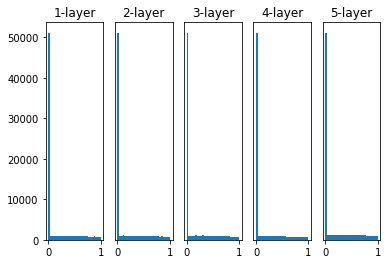

In [24]:
# 구현
import numpy as np
import matplotlib.pyplot as plt

def sigmoid(x):
    return 1/(1+np.exp(-x))

def ReLU(x):
    return np.maximum(0, x)

x = np.random.randn(1000, 100)
node_num = 100
hidden_layer_size = 5
activations = {}

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]
    
    # W = np.random.randn(node_num, node_num)*1
    # W = np.random.randn(node_num, node_num)*0.01
    # W = np.random.randn(node_num, node_num)*np.sqrt(1.0/node_num)
    W = np.random.randn(node_num, node_num)*np.sqrt(2.0/node_num)

    a = np.dot(x, W)
    #z = sigmoid(a)
    z = ReLU(a)
    activations[i] = z

for i,a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1)+"-layer")

    if i != 0:
        plt.yticks([], [])
        
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()

>> ![standard_deviation_1](pic/standard_deviation_1.png)
>>  
>> * 층: 5개
>> * 각 층의 뉴런: 100개
>> * 입력 데이터: 1000개의 무작위 정규분포 데이터
>> * 활성화 함수: Sigmoid function
>> * 가중치 분포에 주의해야 함
>> * 위 구현에서는 표준편차가 1인 정규분포를 이용함, 이 분포된 정도(표준편차)를 바꿔가며 활성화값들의 분포가 어떻게 변화하는지 관찰하는 것이 이 실험의 목적
>> * 각 층의 활성화값들이 0과 1에 치우쳐 분포
>> * 위 구현에서 사용한 Sigmoid function은 그 출력이 0에 가까워지면 그 미분은 0에 다가감  
>> &nbsp; &nbsp; &rarr; 데이터가 0과 1에 치우쳐 분포하게 되면 역전파의 기울기 값이 점점 작아지다가 사라짐  
>> &nbsp; &nbsp; &rarr; 기울기 소실(gradient vanishing) 문제, 층을 깊게 하는 딥러닝에서는 기울기 소실은 더 심각한 문제가 될 수 있음
>>  

>> ![standard_deviation_0.01](pic/standard_deviation_0.01.png)
>> * 표준편차를 0.01로 한 정규분포의 경우 각 층의 활성화값 분포
>> * 0.5 부근에 집중되어 있음  
>> &nbsp; &nbsp; &rarr; 0과 1로 치우치지는 않아 기울기 소실 문제는 일어나지 않지만, 활성화값들이 치우쳤다는 것은 표현력 관점에서는 큰 문제가 있음  
>> &nbsp; &nbsp; &rarr; 이 상황에서는 다수의 뉴런이 거의 같은 값을 출력하고 있으니 뉴런을 여러 개 둔 의미가 없어짐

>> 따라서 활성화값들이 치우치면 표현력을 제한한다는 관점에서 문제가 됨  
>> 각 층의 활성화값들은 적당히 고루 분포되어야 함  
>> 층과 층 사이에 적당하게 다양한 데이터가 흐르게 해야 신경망 학습이 효율적으로 진행되기 때문  
>> 반대로 치우친 데이터가 흐르면 기울기 소실이나 표현력 제한 문제에 빠져 학습이 잘 이루어지지 않음

>> Xavier 초깃값
>> * Xavier Glorot와 Yoshua Bengio의 논문에서 권장하는 가중치 초깃값
>> * 일반적인 딥러닝 프레임워크들이 표준적으로 이용
>> * 논문은 각 층의 활성화값들을 광범위하게 분포시킬 목적으로 가중치의 적절한 분포를 찾고자 함
>> * 앞 계층의 노드가 $n$ 개라면 표준편차가 $\frac{1}{\sqrt{n}}$ 인 분포를 사용하면 된다는 결론을 이끌어 냄
>>  
>> ![xavier](pic/xavier.png)
>>   
>> Xavier 초깃값을 사용하면 앞 층에 노드가 많을수록 대상 노드의 초깃값으로 설정하는 가중치가 좁게 펴짐  
>>  
>> ![standard_deviation_xavier](pic/standard_deviation_xavier.png)
>>  
>> * 층이 깊어지면서 형태가 다소 일그러지지만, 앞에서 본 방식보다는 확실히 넓게 분포됨
>> * 각 층에 흐르는 데이터는 적당히 퍼져 있으므로, Sigmoid function의 표현력도 제한받지 않고 학습이 효율적으로 이루어질 것 
>> * 오른쪽으로 갈수록 일그러지는 것은 sigmoid function 대신 tanh function을 이용하면 개선됨
>> * tanh function도 sigmoid function과 같은 'S'자 모양 곡선 함수
>> * tanh function은 원점(0, 0)에서 대칭인 S곡선인 반면, sigmoid function은 (x,y) = (0, 0.5)에서 대칭인 S곡선
>> * 활성화 함수용으로는 원점에서 대칭인 함수가 바람직하다고 알려져 있음

>> ##### ReLU를 사용할 때의 가중치 초깃값
>> Xavier 초깃값은 활성화 함수가 선형인 것을 전제로 이끈 결과  
>> Sigmoid function과 tanh function 함수는 좌우 대칭이라 중앙 부근이 선형인 함수로 볼 수 있음  
>> &nbsp; &nbsp; &rarr; Xavier 초깃값이 적당함  
>>  
>> 반면 ReLU를 이용할 때는 ReLU에 특화된 초깃값을 이용하라고 권장  
>> 이 특화된 초깃값을 찾아낸 Kaiming He의 이름을 따 He 초깃값이라 함
>>
>> He 초깃값
>> * 앞 계층의 노드가 $n$ 개일 때, $\sqrt{\frac{2}{n}}$ 인 정규분포를 사용
>> * Xaiver 초깃값은 $\sqrt{\frac{2}{n}}$  
>> &nbsp; &nbsp; &rarr; ReLU는 음의 영역이 0이라서 더 넓게 분포시키기 위해 2배의 계수가 필요하다고 (직감적으로) 해석할 수 있음
>>  
>> ![activations_spread_relu](pic/activations_spread_relu.png)
>> 
>> 표준편차 = 0.01
>> * 각 층의 활성화값들은 아주 작은 값들
>> * 신경망에 아주 작은 데이터가 흐른다는 것은 역전파 때 가중치의 기울기 역시 작아진다는 뜻
>> &nbsp; &nbsp; &rarr; 이는 중대한 문제이며, 실제로도 학습이 거의 이뤄지지 않을 것
>>  
>> Xavier 초깃값
>> * 층이 깊어지면서 치우침이 조금씩 커짐
>> * 실제로 층이 깊어지면 활성화값들의 치우침도 커지고, 학습할 때 '기울기 소실' 문제를 일으킴
>>  
>> He 초깃값
>> * 모든 층에서 균일하게 분포
>> * 층이 깊어져도 분포가 균일하게 유지
>> &nbsp; &nbsp; &rarr; 역전파 때도 적절한 값이 나올 것으로 기대

>> 이상의 실험 결과를 바탕으로
>> * 활성화 함수: ReLU &rarr; He 초깃값
>>  
>> * 활성화 함수: Sigmoid, tanh (S자 모양 곡선) &rarr; Xavier 초깃값


>> ##### MNIST 데이터셋으로 본 가중치 초깃값 비교
>> 실제 데이터를 가지고 가중치의 초깃값을 주는 방법이 신경망 학습에 얼마나 영향을 주는지 알아볼 예정

===========iteration:0===========
std=0.01:2.3024906187624805
Xavier:2.320218334259964
He:2.467704672824771
===========iteration:100===========
std=0.01:2.302407607924717
Xavier:2.2693165464693013
He:1.6659291668038774
===========iteration:200===========
std=0.01:2.299268871180098
Xavier:2.159679372363867
He:0.8323954915906572
===========iteration:300===========
std=0.01:2.3027872971932233
Xavier:1.9232582139518815
He:0.5989196121360577
===========iteration:400===========
std=0.01:2.2995279093215624
Xavier:1.4276477205260458
He:0.47989956054138677
===========iteration:500===========
std=0.01:2.3028288613831824
Xavier:0.9761506033763876
He:0.3337547618581814
===========iteration:600===========
std=0.01:2.2999969447321544
Xavier:0.7853394580098316
He:0.31972473635706944
===========iteration:700===========
std=0.01:2.3044278206739097
Xavier:0.592332132318945
He:0.2646844760132683
===========iteration:800===========
std=0.01:2.3023929527358264
Xavier:0.4979003745233773
He:0.279881610354010

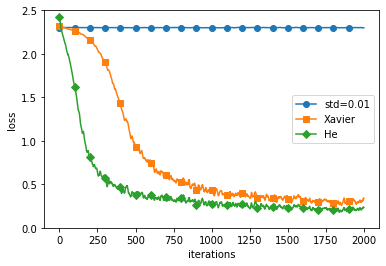

In [25]:
# 활성화 함수: ReLU
# 0.01, Xavier, He
import os, sys
sys.path.append(os.pardir)
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.util import smooth_curve
from common.multi_layer_net import MultiLayerNet
from common.optimizer import SGD

# 0. MNIST 데이터 읽기==========
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

train_size = x_train.shape[0]
batch_size = 128
max_iterations = 2000


# 1. 실험용 설정==========
weight_init_types = {'std=0.01': 0.01, 'Xavier': 'sigmoid', 'He': 'relu'}
optimizer = SGD(lr=0.01)

networks = {}
train_loss = {}
for key, weight_type in weight_init_types.items():
    networks[key] = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100],
                                  output_size=10, weight_init_std=weight_type)
    train_loss[key] = []


# 2. 훈련 시작==========
for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    for key in weight_init_types.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizer.update(networks[key].params, grads)
    
        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)
    
    if i % 100 == 0:
        print("===========" + "iteration:" + str(i) + "===========")
        for key in weight_init_types.keys():
            loss = networks[key].loss(x_batch, t_batch)
            print(key + ":" + str(loss))


# 3. 그래프 그리기==========
markers = {'std=0.01': 'o', 'Xavier': 's', 'He': 'D'}
x = np.arange(max_iterations)
for key in weight_init_types.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 2.5)
plt.legend()
plt.show()

>> * 활성화 함수: ReLU
>>  
>> * `std=0.01`일 때는 학습이 전혀 이뤄지지 않음  
>> &nbsp; &nbsp; &rarr; 활성화 값의 분포에서 본 것처럼 순전파 때 너무 작은 값(0 근처로 밀집한 데이터)이 흐르기 때문  
>> &nbsp; &nbsp; &rarr; 역전파 때의 기울기도 작아져 가중치가 거의 갱신되지 않음  
>> * Xavier와 He의 경우는 학습이 순조롭게 이뤄지고 있음  
>> &nbsp; &nbsp; &rarr; 학습 진도는 He가 더 빠름

>> 기중치의 초깃값은 신경망 학습에 아주 중요한 포인트  
>>  
>> 가중치의 초깃값에 따라 신경망 학습의 성패가 갈리는 경우가 많음  
>> 

> ### **6.3** 배치 정규화
>>  
>> 지금까지 각 층의 활성화값 분포를 관찰해보며, 가중치의 초깃값을 적절히 설정하면 각 층의 활성화값 분포가 적당히 퍼지면서 학습이 원활하게 수행됨을 배움
>>  
>> 그렇다면 각 층이 활성화를 적당히 퍼뜨리도록 '강제'하면 어떨까?  
>> &nbsp; &nbsp; &rarr; 배치 정규화(Batch Normalization)의 아이디어  
>>  
>> ##### 배치 정규화 알고리즘  
>> 배치 정규화가 주목받는 이유
>> * 학습을 빨리 진행할 수 있다 (학습 속도 개선)
>> * 초깃값에 크게 의존하지 않는다 (초깃값 선택으로부터 자유로움)
>> * 오버피팅을 억제한다 (드롭아웃 등의 필요성 감소)  
>>  
>> 배치 정규화의 기본 아이디어는 각 층에서의 활성화값이 적당히 분포되도록 조정하는 것  
>> &nbsp; &nbsp; &rarr; 데이터 분포를 정규화하는 '배치 정규화 (Batch Norm) 계층'을 신경망에 삽입  
>>  
>> ![pic/batch_norm](pic/batch_norm.png)
>>  
>> 배치 정규화는 그 이름과 같이 학습 시 미니배치를 단위로 정규화함  
>> &nbsp; &nbsp; &rarr; 구체적으로는 데이터 분포가 평균이 0, 분산이 1이 되도록 정규화함
>> 
>> * [식 6.7]
>> * $ \mu_B \larr \frac{1}{m} \sum\limits_{i=1}^m x_i $
>>  
>> * $ \sigma^2_b \larr \frac{1}{m} \sum\limits_{i=1}^m (x_i - \mu_B)^2 $
>> * $ \hat{x}_i \larr \frac{x_i - \mu_B}{\sqrt{\sigma^2_B + \epsilon}} $
>>      * B: $={x_1, x_2, ..., x_m}$, 미니배치
>>      * $\mu_B$: $m$개의 입력 데이터의 집합에 대한 평균
>>      * $\sigma^2_B$: $m$개의 입력 데이터의 집합에 대한 분산
>>      * $\epsilon$: 작은 값(10e-7 등)으로, 0으로 나누는 사태를 예방
>>  
>> * 식 6.7은 단순히 미니배치 입력 데이터 ${x_1, x_2, ..., x_m}$을 평균 0, 분산 1인 데이터 ${\hat{X}_1, \hat{X}_2, ..., \hat{X}_m}$으로 변환하는 일을 함
>> * 이 처리를 활성화 함수 앞(혹은 뒤)에 삽입함으로써 데이터 분포가 덜 치우치게 할 수 있음
>>  

>> * 배치 정규화 계층마다 이 정규화된 데이터에 고유한 확대(scale)와 이동(shift)변환을 수행함
>> * $ y_i \larr \gamma \hat{x}_i + \beta $ &nbsp; &nbsp; &nbsp; [식 6.8]
>>      * $\gamma$: 확대 scale, 1부터 시작, 학습하면서 적합한 값으로 조정
>>      * $\beta$: 이동 shift, 0부터 시작, 학습하면서 적합한 값으로 조정

>> 이상이 배치 정규화의 알고리즘  
>>  
>> 배치 정규화 알고리즘은 신경망에서 순전파 때 적용됨  
>>  
>> 이를 계산 그래프로 나타내면 다음과 같음
>> 
>> ![batch_norm_cal_g](pic/batch_norm_cal_g.png)

>> ##### 배치 정규화의 효과
>> 배치 정규화 계층을 사용한 실험 
>>   
>> MNIST 데이터셋을 사용하여 배치 정규화 계층을 사용할 때와 사용하지 않을 때의 학습 진도가 어떻게 달라지는지를 볼 예정  

============== 1/16 ==============
epoch:0 | 0.117 - 0.086


/Users/munpyeong-an/Desktop/vacation project/10eace/../DLS_git_clone/common/multi_layer_net_extend.py:104: RuntimeWarning: overflow encountered in square
  weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W**2)
/Users/munpyeong-an/Desktop/vacation project/10eace/../DLS_git_clone/common/multi_layer_net_extend.py:104: RuntimeWarning: invalid value encountered in double_scalars
  weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W**2)
/Users/munpyeong-an/Desktop/vacation project/10eace/../DLS_git_clone/common/functions.py:34: RuntimeWarning: invalid value encountered in subtract
  x = x - np.max(x, axis=0)
/Users/munpyeong-an/Desktop/vacation project/10eace/../DLS_git_clone/common/functions.py:56: RuntimeWarning: invalid value encountered in log
  return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size


epoch:1 | 0.097 - 0.092
epoch:2 | 0.097 - 0.09
epoch:3 | 0.097 - 0.124
epoch:4 | 0.097 - 0.129
epoch:5 | 0.097 - 0.143
epoch:6 | 0.097 - 0.17
epoch:7 | 0.097 - 0.192
epoch:8 | 0.097 - 0.209
epoch:9 | 0.097 - 0.236
epoch:10 | 0.097 - 0.26
epoch:11 | 0.097 - 0.28
epoch:12 | 0.097 - 0.304
epoch:13 | 0.097 - 0.311
epoch:14 | 0.097 - 0.335
epoch:15 | 0.097 - 0.345
epoch:16 | 0.097 - 0.376
epoch:17 | 0.097 - 0.376
epoch:18 | 0.097 - 0.388
epoch:19 | 0.097 - 0.41


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


============== 2/16 ==============
epoch:0 | 0.093 - 0.091
epoch:1 | 0.097 - 0.09
epoch:2 | 0.097 - 0.106
epoch:3 | 0.097 - 0.139
epoch:4 | 0.097 - 0.16
epoch:5 | 0.097 - 0.169
epoch:6 | 0.097 - 0.199
epoch:7 | 0.097 - 0.228
epoch:8 | 0.097 - 0.262
epoch:9 | 0.097 - 0.291
epoch:10 | 0.097 - 0.31
epoch:11 | 0.097 - 0.341
epoch:12 | 0.097 - 0.364
epoch:13 | 0.097 - 0.388
epoch:14 | 0.097 - 0.406
epoch:15 | 0.097 - 0.424
epoch:16 | 0.097 - 0.451
epoch:17 | 0.097 - 0.459
epoch:18 | 0.097 - 0.481
epoch:19 | 0.097 - 0.507


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


============== 3/16 ==============
epoch:0 | 0.106 - 0.114
epoch:1 | 0.274 - 0.144
epoch:2 | 0.366 - 0.167
epoch:3 | 0.483 - 0.2
epoch:4 | 0.565 - 0.24
epoch:5 | 0.616 - 0.296
epoch:6 | 0.67 - 0.329
epoch:7 | 0.702 - 0.358
epoch:8 | 0.737 - 0.393
epoch:9 | 0.77 - 0.423
epoch:10 | 0.793 - 0.459
epoch:11 | 0.822 - 0.48
epoch:12 | 0.841 - 0.508
epoch:13 | 0.854 - 0.539
epoch:14 | 0.866 - 0.552
epoch:15 | 0.875 - 0.568
epoch:16 | 0.891 - 0.594
epoch:17 | 0.904 - 0.621
epoch:18 | 0.913 - 0.634
epoch:19 | 0.92 - 0.659


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


============== 4/16 ==============
epoch:0 | 0.107 - 0.107
epoch:1 | 0.236 - 0.15
epoch:2 | 0.365 - 0.202
epoch:3 | 0.47 - 0.269
epoch:4 | 0.527 - 0.332
epoch:5 | 0.582 - 0.391
epoch:6 | 0.634 - 0.446
epoch:7 | 0.661 - 0.507
epoch:8 | 0.679 - 0.552
epoch:9 | 0.72 - 0.582
epoch:10 | 0.738 - 0.616
epoch:11 | 0.762 - 0.651
epoch:12 | 0.764 - 0.686
epoch:13 | 0.793 - 0.701
epoch:14 | 0.798 - 0.716
epoch:15 | 0.818 - 0.739
epoch:16 | 0.824 - 0.757
epoch:17 | 0.835 - 0.77
epoch:18 | 0.851 - 0.78
epoch:19 | 0.863 - 0.794


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


============== 5/16 ==============
epoch:0 | 0.131 - 0.1
epoch:1 | 0.133 - 0.175
epoch:2 | 0.138 - 0.294
epoch:3 | 0.141 - 0.383
epoch:4 | 0.141 - 0.474
epoch:5 | 0.151 - 0.532
epoch:6 | 0.157 - 0.587
epoch:7 | 0.163 - 0.651
epoch:8 | 0.186 - 0.705
epoch:9 | 0.216 - 0.742
epoch:10 | 0.227 - 0.78
epoch:11 | 0.253 - 0.795
epoch:12 | 0.252 - 0.817
epoch:13 | 0.271 - 0.826
epoch:14 | 0.288 - 0.846
epoch:15 | 0.306 - 0.855
epoch:16 | 0.301 - 0.859
epoch:17 | 0.313 - 0.869
epoch:18 | 0.315 - 0.877
epoch:19 | 0.327 - 0.89


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


============== 6/16 ==============
epoch:0 | 0.1 - 0.119
epoch:1 | 0.107 - 0.183
epoch:2 | 0.117 - 0.402
epoch:3 | 0.116 - 0.569
epoch:4 | 0.116 - 0.642
epoch:5 | 0.117 - 0.683
epoch:6 | 0.117 - 0.722
epoch:7 | 0.116 - 0.762
epoch:8 | 0.117 - 0.789
epoch:9 | 0.117 - 0.812
epoch:10 | 0.117 - 0.826
epoch:11 | 0.117 - 0.841
epoch:12 | 0.117 - 0.869
epoch:13 | 0.117 - 0.883
epoch:14 | 0.117 - 0.9
epoch:15 | 0.117 - 0.91
epoch:16 | 0.117 - 0.928
epoch:17 | 0.117 - 0.934


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


epoch:18 | 0.117 - 0.941
epoch:19 | 0.117 - 0.945
============== 7/16 ==============
epoch:0 | 0.117 - 0.102
epoch:1 | 0.115 - 0.281
epoch:2 | 0.117 - 0.6
epoch:3 | 0.117 - 0.754
epoch:4 | 0.116 - 0.806
epoch:5 | 0.117 - 0.832
epoch:6 | 0.117 - 0.859
epoch:7 | 0.117 - 0.876
epoch:8 | 0.117 - 0.891
epoch:9 | 0.117 - 0.918
epoch:10 | 0.117 - 0.928
epoch:11 | 0.117 - 0.938
epoch:12 | 0.117 - 0.952
epoch:13 | 0.116 - 0.961
epoch:14 | 0.117 - 0.969
epoch:15 | 0.116 - 0.975
epoch:16 | 0.117 - 0.976
epoch:17 | 0.151 - 0.983


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


epoch:18 | 0.117 - 0.989
epoch:19 | 0.117 - 0.99
============== 8/16 ==============
epoch:0 | 0.102 - 0.09
epoch:1 | 0.117 - 0.405
epoch:2 | 0.117 - 0.768
epoch:3 | 0.117 - 0.828
epoch:4 | 0.117 - 0.868
epoch:5 | 0.117 - 0.899
epoch:6 | 0.117 - 0.926
epoch:7 | 0.116 - 0.948
epoch:8 | 0.116 - 0.968
epoch:9 | 0.116 - 0.98
epoch:10 | 0.116 - 0.981
epoch:11 | 0.116 - 0.991
epoch:12 | 0.116 - 0.994
epoch:13 | 0.116 - 0.995
epoch:14 | 0.116 - 0.996
epoch:15 | 0.117 - 0.998
epoch:16 | 0.116 - 0.998
epoch:17 | 0.116 - 0.998


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


epoch:18 | 0.116 - 0.999
epoch:19 | 0.116 - 0.999
============== 9/16 ==============
epoch:0 | 0.094 - 0.145
epoch:1 | 0.116 - 0.535
epoch:2 | 0.117 - 0.657
epoch:3 | 0.116 - 0.758
epoch:4 | 0.116 - 0.801
epoch:5 | 0.117 - 0.838
epoch:6 | 0.116 - 0.854
epoch:7 | 0.117 - 0.879
epoch:8 | 0.117 - 0.894
epoch:9 | 0.117 - 0.9
epoch:10 | 0.117 - 0.933
epoch:11 | 0.117 - 0.984
epoch:12 | 0.117 - 0.994
epoch:13 | 0.117 - 0.999
epoch:14 | 0.117 - 0.998
epoch:15 | 0.117 - 0.999
epoch:16 | 0.117 - 1.0
epoch:17 | 0.117 - 1.0


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


epoch:18 | 0.117 - 1.0
epoch:19 | 0.117 - 1.0
============== 10/16 ==============
epoch:0 | 0.097 - 0.168
epoch:1 | 0.097 - 0.511
epoch:2 | 0.094 - 0.7
epoch:3 | 0.117 - 0.877
epoch:4 | 0.117 - 0.893
epoch:5 | 0.117 - 0.938
epoch:6 | 0.117 - 0.964
epoch:7 | 0.117 - 0.97
epoch:8 | 0.116 - 0.982
epoch:9 | 0.116 - 0.989
epoch:10 | 0.116 - 0.988
epoch:11 | 0.116 - 0.99
epoch:12 | 0.116 - 0.982
epoch:13 | 0.116 - 0.941
epoch:14 | 0.116 - 0.991
epoch:15 | 0.116 - 0.992
epoch:16 | 0.116 - 0.996
epoch:17 | 0.116 - 0.996


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


epoch:18 | 0.116 - 0.996
epoch:19 | 0.116 - 0.996
============== 11/16 ==============
epoch:0 | 0.099 - 0.198
epoch:1 | 0.117 - 0.468
epoch:2 | 0.117 - 0.556
epoch:3 | 0.116 - 0.696
epoch:4 | 0.117 - 0.74
epoch:5 | 0.117 - 0.745
epoch:6 | 0.117 - 0.792
epoch:7 | 0.117 - 0.766
epoch:8 | 0.117 - 0.88
epoch:9 | 0.117 - 0.855
epoch:10 | 0.117 - 0.88
epoch:11 | 0.117 - 0.865
epoch:12 | 0.116 - 0.796
epoch:13 | 0.116 - 0.855
epoch:14 | 0.116 - 0.893
epoch:15 | 0.116 - 0.897
epoch:16 | 0.116 - 0.88
epoch:17 | 0.116 - 0.894


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


epoch:18 | 0.116 - 0.9
epoch:19 | 0.116 - 0.902
============== 12/16 ==============
epoch:0 | 0.116 - 0.113
epoch:1 | 0.117 - 0.597
epoch:2 | 0.116 - 0.623
epoch:3 | 0.116 - 0.742
epoch:4 | 0.116 - 0.674
epoch:5 | 0.117 - 0.733
epoch:6 | 0.117 - 0.754
epoch:7 | 0.116 - 0.778
epoch:8 | 0.116 - 0.776
epoch:9 | 0.117 - 0.843
epoch:10 | 0.117 - 0.819
epoch:11 | 0.116 - 0.826
epoch:12 | 0.116 - 0.863
epoch:13 | 0.116 - 0.875
epoch:14 | 0.117 - 0.877
epoch:15 | 0.116 - 0.84
epoch:16 | 0.117 - 0.867
epoch:17 | 0.117 - 0.883


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


epoch:18 | 0.117 - 0.888
epoch:19 | 0.117 - 0.899
============== 13/16 ==============
epoch:0 | 0.099 - 0.142
epoch:1 | 0.117 - 0.4
epoch:2 | 0.117 - 0.51
epoch:3 | 0.117 - 0.568
epoch:4 | 0.117 - 0.547
epoch:5 | 0.117 - 0.578
epoch:6 | 0.117 - 0.584
epoch:7 | 0.117 - 0.614
epoch:8 | 0.117 - 0.608
epoch:9 | 0.117 - 0.569
epoch:10 | 0.117 - 0.612
epoch:11 | 0.117 - 0.613
epoch:12 | 0.117 - 0.619
epoch:13 | 0.117 - 0.652
epoch:14 | 0.117 - 0.684
epoch:15 | 0.117 - 0.669
epoch:16 | 0.117 - 0.791
epoch:17 | 0.117 - 0.801


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


epoch:18 | 0.117 - 0.805
epoch:19 | 0.117 - 0.811
============== 14/16 ==============
epoch:0 | 0.1 - 0.23
epoch:1 | 0.099 - 0.414
epoch:2 | 0.116 - 0.509
epoch:3 | 0.117 - 0.587
epoch:4 | 0.116 - 0.665
epoch:5 | 0.116 - 0.665
epoch:6 | 0.116 - 0.664
epoch:7 | 0.117 - 0.661
epoch:8 | 0.117 - 0.689
epoch:9 | 0.117 - 0.699
epoch:10 | 0.117 - 0.661
epoch:11 | 0.117 - 0.701
epoch:12 | 0.117 - 0.706
epoch:13 | 0.117 - 0.707
epoch:14 | 0.117 - 0.779
epoch:15 | 0.117 - 0.794
epoch:16 | 0.117 - 0.711
epoch:17 | 0.117 - 0.804


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


epoch:18 | 0.117 - 0.81
epoch:19 | 0.117 - 0.811
============== 15/16 ==============
epoch:0 | 0.105 - 0.124
epoch:1 | 0.116 - 0.224
epoch:2 | 0.117 - 0.377
epoch:3 | 0.117 - 0.379
epoch:4 | 0.117 - 0.393
epoch:5 | 0.117 - 0.482
epoch:6 | 0.117 - 0.483
epoch:7 | 0.117 - 0.49
epoch:8 | 0.117 - 0.51
epoch:9 | 0.116 - 0.506
epoch:10 | 0.117 - 0.509
epoch:11 | 0.116 - 0.509
epoch:12 | 0.116 - 0.509
epoch:13 | 0.117 - 0.511
epoch:14 | 0.116 - 0.511
epoch:15 | 0.116 - 0.51
epoch:16 | 0.117 - 0.51
epoch:17 | 0.117 - 0.511


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


epoch:18 | 0.117 - 0.511
epoch:19 | 0.117 - 0.512
============== 16/16 ==============
epoch:0 | 0.094 - 0.114
epoch:1 | 0.117 - 0.198
epoch:2 | 0.116 - 0.272
epoch:3 | 0.116 - 0.397
epoch:4 | 0.116 - 0.376
epoch:5 | 0.116 - 0.472
epoch:6 | 0.117 - 0.429
epoch:7 | 0.117 - 0.492
epoch:8 | 0.116 - 0.469
epoch:9 | 0.117 - 0.485
epoch:10 | 0.117 - 0.498
epoch:11 | 0.117 - 0.477
epoch:12 | 0.117 - 0.484
epoch:13 | 0.117 - 0.492
epoch:14 | 0.117 - 0.481
epoch:15 | 0.117 - 0.463
epoch:16 | 0.117 - 0.526
epoch:17 | 0.117 - 0.473
epoch:18 | 0.117 - 0.529
epoch:19 | 0.116 - 0.528


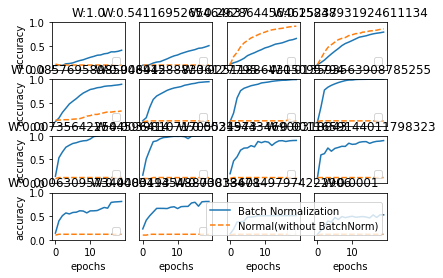

In [22]:
# 구현
import sys, os
sys.path.append(os.pardir)
import numpy as np
import matplotlib.pyplot as plt
from DLS_git_clone.dataset.mnist import load_mnist
from DLS_git_clone.common.multi_layer_net_extend import MultiLayerNetExtend
from DLS_git_clone.common.optimizer import SGD, Adam

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 학습 데이터를 줄임
x_train = x_train[:1000]
t_train = t_train[:1000]

max_epochs = 20
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.01


def __train(weight_init_std):
    bn_network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100], output_size=10, 
                                    weight_init_std=weight_init_std, use_batchnorm=True)
    network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100], output_size=10,
                                weight_init_std=weight_init_std)
    optimizer = SGD(lr=learning_rate)
    
    train_acc_list = []
    bn_train_acc_list = []
    
    iter_per_epoch = max(train_size / batch_size, 1)
    epoch_cnt = 0
    
    for i in range(1000000000):
        batch_mask = np.random.choice(train_size, batch_size)
        x_batch = x_train[batch_mask]
        t_batch = t_train[batch_mask]
    
        for _network in (bn_network, network):
            grads = _network.gradient(x_batch, t_batch)
            optimizer.update(_network.params, grads)
    
        if i % iter_per_epoch == 0:
            train_acc = network.accuracy(x_train, t_train)
            bn_train_acc = bn_network.accuracy(x_train, t_train)
            train_acc_list.append(train_acc)
            bn_train_acc_list.append(bn_train_acc)
    
            print("epoch:" + str(epoch_cnt) + " | " + str(train_acc) + " - " + str(bn_train_acc))
    
            epoch_cnt += 1
            if epoch_cnt >= max_epochs:
                break
                
    return train_acc_list, bn_train_acc_list


# 그래프 그리기==========
weight_scale_list = np.logspace(0, -4, num=16)
x = np.arange(max_epochs)

for i, w in enumerate(weight_scale_list):
    print( "============== " + str(i+1) + "/16" + " ==============")
    train_acc_list, bn_train_acc_list = __train(w)
    
    plt.subplot(4,4,i+1)
    plt.title("W:" + str(w))
    if i == 15:
        plt.plot(x, bn_train_acc_list, label='Batch Normalization', markevery=2)
        plt.plot(x, train_acc_list, linestyle = "--", label='Normal(without BatchNorm)', markevery=2)
    else:
        plt.plot(x, bn_train_acc_list, markevery=2)
        plt.plot(x, train_acc_list, linestyle="--", markevery=2)

    plt.ylim(0, 1.0)
    if i % 4:
        plt.yticks([])
    else:
        plt.ylabel("accuracy")
    if i < 12:
        plt.xticks([])
    else:
        plt.xlabel("epochs")
    plt.legend(loc='lower right')
    
plt.show()



>> ![comparison_batch_norm_normal](pic/comparison_batch_norm_normal.png)
>>  
>> * 배치 정규화가 학습을 빨리 진전시키고 있음
>>  
>> ![pic/accuracy_comparison](pic/accuracy_comparison.png)
>>  
>> * 거의 모든 경우에서 배치 정규화를 사용할 때의 학습 진도가 빠른 것으로 나타남. 실제로 배치 정규화를 이용하지 않는 경우엔 초깃값이 잘 분포되어 있지 않으면 학습이 전혀 진행되지 않는 모습도 확인할 수 있음.  
>>  
>> 배치 정규화를 사용하면 학습이 빨라지며, 가중치 초깃값에 크게 의존하지 않아도 됨

> ### **6.4** 바른 학습을 위해
>>  
>> 기계학습에서는 overfitting이 문제가 되는 일이 많음  
>>  
>> ##### overfitting
>>  
>> overfitting은 주로 다음의 경우에 일어남
>> * 매개변수가 많고 표현력이 높은 모델
>> * 훈련 데이터가 적음
>>  
>> 이 두 조건을 일부러 충족하여 오버피팅 일으키기  
>> &nbsp; &nbsp; &rarr; MNIST 데이터셋의 훈련 데이터 중 300개만 사용  
>> &nbsp; &nbsp; &rarr; 7층 네트워크 사용 (네트워크 복잡성 높이기)  
>> &nbsp; &nbsp; &rarr; 각 층의 뉴런은 100개, 활성화 함수는 ReLU 사용


epoch: 0, train acc: 0.17, test acc: 0.1445
epoch: 1, train acc: 0.18666666666666668, test acc: 0.1647
epoch: 2, train acc: 0.21666666666666667, test acc: 0.1792
epoch: 3, train acc: 0.23, test acc: 0.1914
epoch: 4, train acc: 0.2733333333333333, test acc: 0.2111
epoch: 5, train acc: 0.31333333333333335, test acc: 0.2353
epoch: 6, train acc: 0.34, test acc: 0.2583
epoch: 7, train acc: 0.3466666666666667, test acc: 0.2745
epoch: 8, train acc: 0.37, test acc: 0.2897
epoch: 9, train acc: 0.38666666666666666, test acc: 0.3065
epoch: 10, train acc: 0.4033333333333333, test acc: 0.3231
epoch: 11, train acc: 0.4033333333333333, test acc: 0.3338
epoch: 12, train acc: 0.41333333333333333, test acc: 0.3401
epoch: 13, train acc: 0.42, test acc: 0.3431
epoch: 14, train acc: 0.4, test acc: 0.3404
epoch: 15, train acc: 0.41, test acc: 0.3435
epoch: 16, train acc: 0.4166666666666667, test acc: 0.3459
epoch: 17, train acc: 0.42333333333333334, test acc: 0.347
epoch: 18, train acc: 0.43333333333333335,

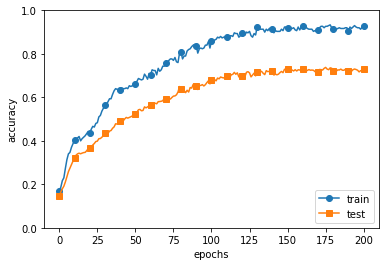

In [5]:
# weight decay, MNIST
import os
import sys
sys.path.append(os.pardir)
import numpy as np
import matplotlib.pyplot as plt
from DLS_git_clone.dataset.mnist import load_mnist
from DLS_git_clone.common.multi_layer_net import MultiLayerNet
from DLS_git_clone.common.optimizer import SGD

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# overfitting을 구현하기 위 학습 데이터 수 줄임
x_train = x_train[:300]
t_train = t_train[:300]

# weight decay (가중치 감쇠) 설정
# weight_decay_lambda = 0   # weight decay를 사용하지 않을 경우
weight_decay_lambda = 0.1

network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100], output_size=10,  weight_decay_lambda=weight_decay_lambda)
optimizer = SGD(lr=0.01)

max_epochs = 201
train_size = x_train.shape[0]
batch_size = 100

train_loss_list = []
train_acc_list = []     # epoch 단위(모든 훈련 데이터를 한 번씩 본 단위)의 정확도 저장
test_acc_list = []      # epoch 단위(모든 훈련 데이터를 한 번씩 본 단위)의 정확도 저장

iter_per_epoch = max(train_size/batch_size, 1)
epoch_cnt = 0

for i in range(1000000000):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    grads = network.gradient(x_batch, t_batch)
    optimizer.update(network.params, grads)

    if i%iter_per_epoch==0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)

        print("epoch: "+str(epoch_cnt)+", train acc: "+str(train_acc)+", test acc: "+str(test_acc))

        epoch_cnt += 1

        if epoch_cnt>=max_epochs:
            break
    
# 그래프 그리기
markers = {'train':'o', 'test':'s'}
x = np.arange(max_epochs)
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()


>> * 훈련 데이터를 사용하여 측정한 정확도는 100, epoch를 지나는 무렵부터 거의 100%
>>  
>> * 시험 데이터에 대해서는 큰 차이를 보임
>> * 정확도가 크게 벌어지는 것은 훈련 데이터에만 적응(fitting)해버린 결과
>> * 훈련 때 사용하지 않은 범용 데이터(시험 데이터)에는 제대로 대응하지 못하는 것을 확인

>> ##### 가중치 감소 (weight decay)
>> overfitting 억제용으로 예로부터 많이 이용해온 방법에는 가중치 감소(weight decay)가 있음  
>>  
>> 학습 과정에서 큰 가중치에 대해서는 그에 상응하는 큰 페널티를 부과하여 overfitting을 억제하는 방법  
>> &nbsp; &nbsp; &rarr; 원래 overfitting은 가중치 매개변수의 값이 커서 발생하는 경우가 많기 때문 
>>  
>>  신경망 학습의 목적은 손실 함수의 값을 줄이는 것  
>> 
>> 이때, 예를 들어 가중치의 제곱 norm ($L2$ norm, 각 원소의 제곱을 더한 것)을 손실 함수에 더함  
>> &nbsp; &nbsp; &rarr; 가중치가 커지는 것을 억제할 수 있음  
>>  
>> 가중치를 $W$라 하면 $L2$ norm에 따른 가중치 감소는 $\frac{1}{2} \lambda W^2$이 되고, 이 $\frac{1}{2} \lambda W^2$을 손실 함수에 더함  
>>   
>> 여기에서 $\lambda$는 정규화의 세기를 조절하는 하이퍼파라미터  
>> &nbsp; &nbsp; &rarr; $\lambda$를 크게 설정할수록 큰 가중치에 대한 페널티가 커짐  
>> $\frac{1}{2} \lambda W^2$의 앞쪽 $\frac{1}{2}$은 $\frac{1}{2} \lambda W^2$의 미분 결과인 $\lambda W$를 조정하는 역할의 상수  
>>  
>> 가중치 감소는 모든 가중치 각각의 손실 함수에 $\frac{1}{2} \lambda W^2$을 더함  
>> &nbsp; &nbsp; &rarr; 가중치의 기울기를 구하는 계산에서는 그동안의 오차역전파법에 따른 결과에 정규화 항을 미분한 $\lambda W$를 더함
>>  
>>  ![[pic/weight_decay]](pic/weight_decay.png)
>>  
>> * 훈련 데이터에 대한 정확도와 시험 데이터에 대한 정확도에는 여전히 차이가 있지만, 가중치 감소를 이용하지 않은 때와 비교하면 그 차이가 줄어듦  
>> &nbsp; &nbsp; &rarr; overfitting이 억제되었음
>> * 가중치 감소를 이용하지 않은 때와 달리 훈련 데이터에 대한 정확도가 100%에 도달하지 못함


>> ##### 드롭아웃 (Dropout)
>> 앞에서는 overfitting을 억제하는 방식으로 손실 함수에 가중치의 $L2$ norm을 더한 가중치 감소 방법을 설명  
>>  
>> 가중치 감소는 간단하게 구현할 수 있고, 어느 정도 지나친 학습을 억제할 수 있음  
>>  
>> 그러나 신경망 모델이 복잡해지면 가중치 감소만으로는 대응하기 어려워짐  
>> &nbsp; &nbsp; &rarr; 드롭아웃 (Dropout)을 이용함
>>  
>> Dropout
>> * 뉴런을 임의로 삭제하며 학습하는 방법
>> * 훈련 때 은닉층의 뉴런을 무작위로 골라 삭제
>> * 삭제된 뉴런은 그림 6-22와 같이 신호를 전달하지 않게 됨
>> * 훈련 때는 데이터를 흘릴 때마다 삭제할 뉴런을 무작위로 선택
>> * 시험 때는 모든 뉴런에 신호를 전달
>> * 시험 때는 각 뉴런의 출력에 훈련 때 삭제한 비율을 곱하여 출력
>> 
>> ![img](pic/concept_of_dropout.png)

In [6]:
# Dropout 구현
class Dropout:
    def __init__(self, dropout_ratio=0.5):
        self.dropout_ratio = dropout_ratio
        self.mask = None
    
    def forward(self, x, train_flg=True):
        if train_flg:
            self.mask = np.random.rand(*x.shape) > self.dropout_ratio
            return x*self.mask
        else:
            return x*(1.0-self.dropout_ratio)
    
    def backward(self, dout):
        return dout*self.mask

>> * 이해하기 쉽게 구현된 코드
>>  
>> * 순전파를 담당하는 `forward` 메서드에서는 훈련 때(`train_flg=True`)만 잘 계산해두면 시험 때는 단순히 데이터를 흘리기만 하면 됌 
>> * 삭제한 비율은 곱하지 않아도 됌, 실제 딥러닝 framework들도 비율을 곱하지 않음
>> * 훈련 시에는 순전파 때마다 `self.mask`에 삭제할 뉴런을 `False`로 표시함
>> * `self.mask`는 `x`와 형상이 같은 배열을 무작위로 생성하고, 그 값이 `dropout_ratio`보다 큰 원소만 `True`로 설정
>> * 역전파 때의 동작은 ReLU와 같음  
>> &nbsp; &nbsp; &rarr; 순전파 때 신호를 통과시키는 뉴런은 역전파 때도 신호를 그대로 통과 시키고, 순전파 때 통과시키지 않은 뉴런은 역전파 때도 신호를 차단  
>>  
>> Dropout의 효과를 MNIST 데이터셋으로 확인

train loss:2.293792019584088
=== epoch:1, train acc:0.07, test acc:0.0989 ===
train loss:2.2856308446573257
train loss:2.2940822974960664
train loss:2.3199074965804205
=== epoch:2, train acc:0.07, test acc:0.0984 ===
train loss:2.2998257331202177
train loss:2.281795107716303
train loss:2.2959301264455094
=== epoch:3, train acc:0.07666666666666666, test acc:0.0995 ===
train loss:2.293397002529371
train loss:2.2938462011982312
train loss:2.289743800461147
=== epoch:4, train acc:0.07666666666666666, test acc:0.1019 ===
train loss:2.306289729726787
train loss:2.3073342799395946
train loss:2.2945529030937277
=== epoch:5, train acc:0.09333333333333334, test acc:0.1051 ===
train loss:2.2813844983735003
train loss:2.2991939946139524
train loss:2.295439054271099
=== epoch:6, train acc:0.09666666666666666, test acc:0.1072 ===
train loss:2.2811186624697095
train loss:2.2637224147867285
train loss:2.2919200048349384
=== epoch:7, train acc:0.09666666666666666, test acc:0.1086 ===
train loss:2.29345

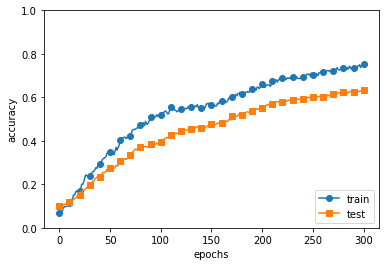

In [9]:
# Dropout, MNIST
import os
import sys
sys.path.append(os.pardir)
import numpy as np
import matplotlib.pyplot as plt
from DLS_git_clone.dataset.mnist import load_mnist
from DLS_git_clone.common.multi_layer_net_extend import MultiLayerNetExtend
from DLS_git_clone.common.trainer import Trainer    # 네트워크 학습 간소화

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# overfitting을 구현하기 위해 학습 데이터 수 줄임
x_train = x_train[:300]
t_train = t_train[:300]

# Dropout 사용 여부와 비율 결정
use_dropout = True
dropout_ratio = 0.2

network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100], output_size=10, use_dropout=use_dropout, dropout_ration=dropout_ratio)
trainer = Trainer(network, x_train, t_train, x_test, t_test, epochs=301, mini_batch_size=100, optimizer='sgd', optimizer_param={'lr':0.01}, verbose=True)
trainer.train()

train_acc_list, test_acc_list = trainer.train_acc_list, trainer.test_acc_list

# 그래프 그리기
markers = {'train':'o', 'test':'s'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

>> ![pic/result.](pic/result_dropout.png)
>>  
>> * 7층 네트워크
>>  
>> * 각 층의 뉴런 수: 100개
>> * 활성화 함수: ReLU
>> * Dropout을 적용하니 훈련 데이터와 시험 데이터에 대한 정확도 차이가 줄어듦
>> * 훈련 데이터에 대한 정확도가 100%에 도달하지도 않음
>> * Dropout을 이용하면 표현력을 높이면서도 overfitting을 억제할 수 있음

>> 기계학습에서는 앙상블 학습 (ensemble learning)을 애용함
>> 
>> ensemble learning
>> * 개별적으로 학습시킨 여러 모델의 출력을 평균 내어 추론하는 방식
>> * 신경망의 맥락에서 이야기하면, 같은(혹은 비슷한) 구조의 네트워크를 5개 준비하여 따로따로 학습시키고, 시험 때는 그 5개의 출력을 평균 내어 답하는 것
>> * 신경망의 정확도가 개선된다는 것이 실험적으로 알려져 있음
>> * Dropout과 밀접함  
>> &nbsp; &nbsp; &rarr; Dropout이 학습 때 뉴런을 무작위로 삭제하는 행위를 매번 다른 모델을 학습시키는 것으로 해석할 수 있음  
>> &nbsp; &nbsp; &rarr; 추론 때는 뉴런의 출력에 삭제한 비율(0.5 등)을 곱함으로써 ensemble learning과 같은 효과를 (대략) 하나의 네트워크로 구현했다고 볼 수 있음

> ### **6.5** 적절한 하이퍼파라미터 (hyper parameter) 값 찾기
> 신경망에는 hyper parameter가 다수 등장
>  
> hyper parameter:
> * 각 층의 뉴런 수
> * 배치 크기
> * 매개변수 갱신 시의 학습률
> * 가중치 감소
> * ...
> 
> 이러한 hyper parameter의 값을 적절히 설정하지 않으면 모델의 성능이 크게 떨어지기도 함  
> 
> hyper parameter의 값은 매우 중요하지만 그 값을 결정하기까지는 일반적으로 많은 시행착오를 겪음  
> 
> hyper parameter의 값을 최대한 효율적으로 탐색하는 방법을 알아봄  
>>  
>> ##### 검증 데이터
>> 지금까지는 데이터셋을 훈련 데이터와 시험 데이터라는 두 가지로 분리해 이용함  
>> 
>> 훈련 데이터로는 학습을 진행, 시험 데이터로는 범용 성능을 평가  
>>  
>> 그렇게 해서 overfitting이 일어나고 있지 않은지, 범용 성능은 어느 정도인지 등을 평가할 수 있었음
>> 
>> 앞으로 hyper parameter를 다양한 값으로 설정하고 검증할 예정, 여기서 주의할 점은 hyper parameter의 성능을 평가할 때는 시험 데이터를 사용해서는 안된다는 것
>> &nbsp; &nbsp; &rarr; 매우 중요하지만 놓치기 쉬움
>>  
>> 같은 성능 평가인데 hyper parameter가 대상일 때는 시험 데이터를 사용해서는 안되는 이유가 무엇일까? 
>> * 시험 데이터를 사용하여 hyper parameter를 조정하면 hyper parameter값이 시험 데이터에 overfitting되기 때문  
>> &nbsp; &nbsp; &rarr; hyper parameter의 값의 '좋음'을 시험 데이터로 확인하게 되므로, hyper parameter 값이 시험 데이터에만 적합하도록 조정됨  
>> &nbsp; &nbsp; &rarr; 다른 데이터에는 적응하지 못하니 범용 성능이 떨어질 수 있음
>>  
>> 따라서 hyper parameter를 조정할 때에는 hyper parameter 전용 확인 데이터 필요
>>
>> 이를 일반적으로 검증 데이터 (validation data)라고 함
>> 
>> 데이터 정리
>> * 훈련 데이터 (training data): 매개변수 학습
>> * 검증 데이터 (validation data): hyper parameter 성능 평가
>> * 시험 데이터 (test data): 신경망의 범용 성능 평가

>> 데이터셋에 따라서는 훈련 데이터, 검증 데이터, 시험 데이터를 미리 분리해둔 것도 있음
>> 
>> 하지만 MNIST 데이터셋은 훈련 데이터와 시험 데이터로만 분리되어 있음
>> 
>> 이런 경우에는 (필요하면) 사용자가 직접 데이터를 분리해야 함
>> 
>> MNIST 데이터셋에서 검증 데이터를 얻는 가장 간단한 방법은 훈련 데이터 중 20% 정도를 검증 데이터로 먼저 분리하는 것

In [15]:
# validation data 분리
from DLS_git_clone.common.util import shuffle_dataset

(x_train, t_train), (x_test, t_test) = load_mnist()

# training data를 뒤섞음
x_train, t_train = shuffle_dataset(x_train, t_train)

# 20%를 validation data로 분할
validation_rate = 0.20
validation_num = int(x_train.shape[0]*validation_rate)

x_val = x_train[:validation_num]
t_val = t_train[:validation_num]
x_train = x_train[validation_num:]
t_train = t_train[validation_num:]

>> * 훈련 데이터를 분리하기 전에 입력 데이터와 정답 레이블을 뒤섞음  
>> &nbsp; &nbsp; &rarr; 데이터셋 안의 데이터가 치우쳐 있을지도 모르기 때문
>> 
>> * `shuffle_dataset`: np.random.shuffle을 이용한 함수

>> ##### hyper parameter 최적화
>> hyper parameter를 최적화할 때 핵심은 hyper parameter의 '최적 값'이 존재하는 범위를 조금씩 줄여가는 것  
>> 
>> 범위를 조금씩 줄이려면 우선 대략적인 범위를 설정하고 그 범위에서 무작위로 hyper parameter값을 골라낸(sampling) 후, 그 값으로 정확도를 평가  
>> 
>> 정확도를 잘 살피며 이 작업을 여러 번 반복하여 hyper parameter의 '최적 값'의 범위를 좁혀가는 작업  
>>  
>> 신경망의 hyper parameter 최적화에서는 grid search와 같은 규칙적인 탐색보다는 무작위로 sampling 해 탐색하는 편이 좋은 결과를 낸다고 알려져 있음  
>> &nbsp; &nbsp; &rarr; 최종 정확도에 미치는 영향력이 hyper parameter마다 다르기 때문
>>  
>> 실제로도 0.001에서 1000사이($10^{-3} ~ 10^3$)와 같이 '10의 거듭제곱' 단위로 범위를 지정함  
>> &nbsp; &nbsp; &rarr; 이를 '로그 스케일 (log scale)로 지정'한다고 함
>>  
>> hyper parameter를 최적화할 때는 딥러닝 학습에는 오랜 시간이 걸린다는 점을 기억해야 함  
>> &nbsp; &nbsp; &rarr; 따라서 나쁠 듯한 값은 일찍 포기하는 것이 좋음  
>> &nbsp; &nbsp; &rarr; 학습을 위한 epoch를 작게 하여, 1회 평가에 걸리는 시간을 단축하는 것이 효과적
>>  
>> hyper parameter 최적화
>> * 0단계  
>> &nbsp; &nbsp; &rarr; hyper parameter 값의 범위 설정  
>> 
>> * 1단계  
>> &nbsp; &nbsp; &rarr; 설정된 범위에서 hyper parameter의 값을 무작위로 추출  
>> * 2단계  
>> &nbsp; &nbsp; &rarr; 1단계에서 sampling한 hyper parameter 값을 사용하여 학습하고, validation data로 정확도를 평가 (epoch는 작게 설정)  
>> * 3단계  
>> &nbsp; &nbsp; &rarr; 1단계와 2단계를 특정 횟수(100회 등) 반복하여 그 정확도 결과를 보고 hyper parameter의 범위를 좀혀감
>>  
>> 지금까지 설명한 hyper parameter 최적화 방법은 실용적인 방법
>> 
>> 과학이라기보다는 수행자의 '지혜'와 '직관'에 의존하는 느낌
>> 
>> 좀 더 세련된 기법에는 베이즈 최적화 (Bayesian optimization)이 있음
>>
>> Bayesian optimization은 베이즈 정리 (Bayes' theorem)를 중심으로 한 수학 이론을 구사하여 더 엄밀하고 효율적으로 최적화를 수행

>> ##### hyper parameter 최적화 구현하기
>> MNIST 데이터셋을 사용하여 hyper parameter를 최적화
>> 
>> 학습률과 가중치 감소의 세기를 조절하는 계수(가중치 감소 계수)를 탐색하는 문제 해결
>>
>> 앞서 이야기한대로, hyper parameter의 검증은 그 값을 log scale 범위에서 무작위로 추출해 수행, 파이썬으로는  
>> &nbsp; &nbsp; &rarr; `10**np.random.uniform(-3,3)` 작성
>> 
>> 이 예에서는 가중치 감소 계수를 $10^{-8} ~ 10^{-4}$, 학습률을 $10^{-6} ~ 10^{-2}$범위부터 시작

In [16]:
weight_decay = 10**np.random.uniform(-8, -4)
lr = 10**np.random.uniform(-6, -2)

>> 이렇게 무작위로 추출한 값을 사용하여 학습을 수행  
>>
>> 그 후에는 여러 차례 다양한 hyper parameter 값으로 학습을 반복하며 신경망에 좋을 것 같은 값이 어디에 존재하는지 관찰

val acc:0.08 | lr:3.282476538008575e-05, weight decay:4.8591695170432466e-05
val acc:0.79 | lr:0.008368108777202007, weight decay:1.532186912539212e-05
val acc:0.71 | lr:0.006779014560831042, weight decay:1.0407050331668547e-07
val acc:0.06 | lr:6.825791106302923e-05, weight decay:1.8704606441407372e-06
val acc:0.15 | lr:2.947691002691223e-05, weight decay:6.456581459899114e-06
val acc:0.59 | lr:0.004992093937527763, weight decay:1.8355513465186052e-05
val acc:0.59 | lr:0.0057525446369139106, weight decay:2.8351045905781725e-07
val acc:0.16 | lr:1.4670973537120602e-05, weight decay:1.0887892567538415e-07
val acc:0.1 | lr:1.0049323014987852e-05, weight decay:4.436223730860414e-05
val acc:0.32 | lr:0.0011194944353304205, weight decay:5.53085015728679e-05
val acc:0.1 | lr:0.00010937415113076304, weight decay:4.804897930726922e-05
val acc:0.12 | lr:0.0002431641391349359, weight decay:4.702293515625884e-08
val acc:0.09 | lr:0.00017162500915556073, weight decay:3.9556927695694344e-06
val acc

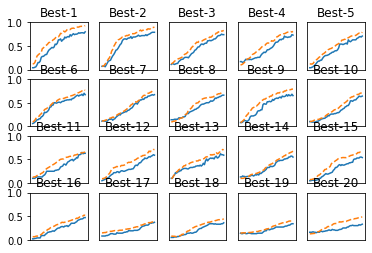

In [19]:
# hyper parameter optimization (learning rate, weight decay coefficient)
# MNIST
import sys, os
sys.path.append(os.pardir)
import numpy as np
import matplotlib.pyplot as plt
from DLS_git_clone.dataset.mnist import load_mnist
from DLS_git_clone.common.multi_layer_net import MultiLayerNet
from DLS_git_clone.common.util import shuffle_dataset
from DLS_git_clone.common.trainer import Trainer

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 결과를 빠르게 얻기 위해 훈련 데이터 줄임
x_train = x_train[:500]
t_train = t_train[:500]

# 20%를 validation data로 분할
validation_rate = 0.20
validation_num = int(x_train.shape[0]*validation_rate)

x_train, t_train = shuffle_dataset(x_train, t_train)

x_val = x_train[:validation_num]
t_val = t_train[:validation_num]

x_train = x_train[validation_num:]
t_train = t_train[validation_num:]

def __train(lr, weight_decay, epocs=50):
    network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100], output_size=10, weight_decay_lambda=weight_decay)
    trainer = Trainer(network, x_train, t_train, x_val, t_val, epochs=epocs, mini_batch_size=100, optimizer='sgd', optimizer_param={'lr':lr}, verbose=False)
    trainer.train()

    return trainer.test_acc_list, trainer.train_acc_list

# hyper parameter 무작위 탐색
optimization_trial = 100
results_val = {}
results_train = {}

for _ in range(optimization_trial):
    # 탐색한 hyper parameter 범위 지정
    weight_decay = 10**np.random.uniform(-8, -4)
    lr = 10**np.random.uniform(-6, -2)

    val_acc_list, train_acc_list = __train(lr, weight_decay)

    print("val acc:"+str(val_acc_list[-1])+" | lr:"+str(lr)+", weight decay:"+str(weight_decay))

    key = "lr:"+str(lr)+", weight decay:"+str(weight_decay)
    results_val[key] = val_acc_list
    results_train[key] = train_acc_list

# 그래프 그리기
print("=========== Hyper-Parameter Optimization Result ===========")

graph_draw_num = 20
col_num = 5
row_num = int(np.ceil(graph_draw_num/col_num))
i = 0

for key, val_acc_list in sorted(results_val.items(), key=lambda x:x[1][-1], reverse=True):
    print("Best-"+str(i+1)+"(val acc:"+str(val_acc_list[-1])+") | "+key)

    plt.subplot(row_num, col_num, i+1)
    plt.title("Best-"+str(i+1))
    plt.ylim(0.0, 1.0)
    if i%5:plt.yticks([])
    plt.xticks([])
    
    x = np.arange(len(val_acc_list))
    plt.plot(x, val_acc_list)
    plt.plot(x, results_train[key], "--")

    i+=1

    if i>=graph_draw_num:
        break

plt.show()

>> ![pic/hyper_parameter_optimization](pic/hyper_parameter_optimization.png)
>> * validation data의 학습 추이를 정확도가 높은 순서로 나열
>> 
>> * 'Best-5' 정도까지는 학습이 순조롭게 진행  
>> &nbsp; &nbsp; &rarr; 'Best-5'까지의 hyper parameter의 값을 보면 학습이 잘 진행될 때의 학습률은 0.001~0.01, 가중치 감소 계수는 $10^{-8} ~ 10^{-6}$ 정도라는 것을 알 수 있음  
>>  
>> ![pic/result_of_hyper_parameter](pic/result_of_hyper_parameter.png)
>>  
>> 이처럼 잘될 것 같은 값의 범위를 관찰하고 범위를 좁혀감  
>> 
>> 그런 다음 그 축소된 범위로 똑같은 작업을 반복
>> 
>> 이렇게 적절한 값이 위치한 범위를 좁혀가다가 특정 단계에서 최종 hyper parameter 값을 하나 선택함